In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pybatteryid import ModelStructure
from pybatteryid.model import load_from_file
from pybatteryid.plotter import plot_time_vs_current, plot_time_vs_voltage

from data import helper

### Example 4 - Model Validation for an LFP Battery

This file contains an example to validate the idnetified battery models for a 3.5 Ah LFP battery. A test current profile as used in [X] is applied as an input to the model to simulate the voltage output.

#### A. Initialize model structure

In [2]:
# The LFP battery being modelled has the capacity around
# 3.5 Ah. The exact value has been calculated by
# coulomb counting during quasi-OCV experiment.
battery_capacity = 13270.180265768407
# The experimental measurements were recorded with 1s
# sampling period.
sampling_period = 1

model_structure = ModelStructure(battery_capacity=battery_capacity, sampling_period=sampling_period)

#### B. Load EMF and Hysteresis data

In [3]:
#
emf_data = helper.load_npy_data('data/lfp/quasi_emf.npy')
model_structure.add_emf_function(emf_data['soc_values'], emf_data['voltage_values'])
# 
hysteresis_data = helper.load_npy_data('data/lfp/hysteresis_data.npy')
model_structure.add_hysteresis_function(hysteresis_data['soc_values'], hysteresis_data['voltage_values'])

#### C. Add Basis Functions

In [4]:
model_structure.add_basis_functions(
    [ 's⁻¹', 'log[s]', 's', 'exp[0.02sqrt[|i|]]', 'd[0.01,0.99]' ],
    [ 'd[0.900,1]', 'd[0.995,1.0]', 'd[0.999,1]' ]
)

#### D. Load battery model

We load the identified battery model from a file.

In [5]:
model = load_from_file( 'results/lfp/model_one_n,l=1,1.npy' )

#### E. Simulate output voltage

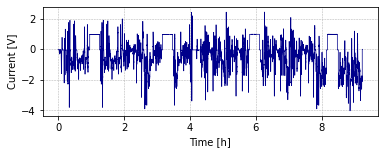

In [6]:
#
dataset = helper.load_npy_data(f'data/lfp/validation_data.npy')
#
plot_time_vs_current([(dataset['time'] / 3600, dataset['current'])],
                     units=('h', 'V'), colors=['darkblue'])

In [7]:
# To perform fair comparison, we provide same number of initial
# voltage values to each model. For example, the model with n=4
# requires four initial voltage values. If n=4 is the largest model
# order to be investigated, then we provide four initial values to
# all models, that is, n=1,2,3,4.
max_model_order = 4
#
voltage_simulated = model_structure.simulate(model, dataset, initial_soc=0.985,
                                             no_of_initial_values=max_model_order)

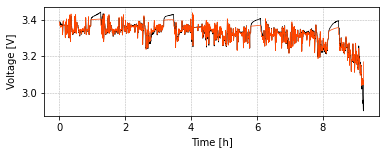

In [8]:
#
plot_time_vs_voltage([(dataset['time'] / 3600, dataset['voltage']), (dataset['time'] / 3600, voltage_simulated)],
                     units=('h', 'V'), colors=['k', 'orangered'])

#### F. Error Analysis

In [9]:
# We define a function that takes a list of indices defining slices
# and calculates error values for the combined region.
def find_rmse_mae_for_subregions(region_slices):
    #
    simulated_voltage_regions = np.concatenate([ voltage_simulated[ idx[0]:idx[1] ] for idx in region_slices ])
    measured_voltage_regions = np.concatenate([  dataset['voltage'][ idx[0]:idx[1] ] for idx in region_slices ])
    #
    rmse = mean_squared_error( simulated_voltage_regions, measured_voltage_regions, squared=False )
    mae = mean_absolute_error( simulated_voltage_regions, measured_voltage_regions )

    return rmse, mae

In [10]:
# We define slices for region A and region B
region_A_slices = [(max_model_order, 3350), (4600, 11330), (12570, 20820), (22100, 29320), (30600, len(voltage_simulated))]
region_As_total = [(dataset['time'][ idx[0]:idx[1] ] / 3600, voltage_simulated[ idx[0]:idx[1] ]) for idx in region_A_slices]
#
region_B_slices = [(3350, 4600), (11330, 12570), (20820, 22100), (29320, 30600)]
region_Bs_total = [(dataset['time'][ idx[0]:idx[1] ] / 3600, voltage_simulated[ idx[0]:idx[1] ]) for idx in region_B_slices]

# We find error values for the whole region
rmse = mean_squared_error( voltage_simulated[max_model_order:], dataset['voltage'][max_model_order:], squared=False )
mae = mean_absolute_error( voltage_simulated[max_model_order:], dataset['voltage'][max_model_order:] )

# We find error values separately for regions A and B
rmse_A, mae_A = find_rmse_mae_for_subregions(region_A_slices)
rmse_B, mae_B = find_rmse_mae_for_subregions(region_B_slices)

print(f"The errors are given as: (RMSE, MAE) = ({rmse * 1e3} mV, {mae * 1e3} mV)")
print(f"Region A -- red: (RMSE, MAE) = ({rmse_A * 1e3} mV, {mae_A * 1e3} mV)")
print(f"Region B -- green: (RMSE, MAE) = ({rmse_B * 1e3} mV, {mae_B * 1e3} mV)")

The errors are given as: (RMSE, MAE) = (13.378653490079138 mV, 8.063439222713887 mV)
Region A -- red: (RMSE, MAE) = (9.671250444512548 mV, 5.303614100044549 mV)
Region B -- green: (RMSE, MAE) = (25.614771625836887 mV, 23.47255390762175 mV)
